從 [wrangle report](https://github.com/wrayz/hw-wrangle-and-analyze-data/blob/master/wrangle_report.html) 我們將三份跟 @WeRateDog 推文相關的資料 wrangling 成一份資料 `twitter_archive_master.csv`，以下是我的分析

In [3]:
import pandas as pd
df = pd.read_csv('twitter_archive_master.csv')
df.head(3)

,tweet_id,text,expanded_urls,name,doggo,floofer,pupper,puppo,favorite_count,lang,retweet_count,source,created_at,rating_ratio,breed
0,892177421306343426,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,Tilly,None,None,None,None,32434,en,6079,iPhone,2017-08-01 00:17:27,1.3,Chihuahua
1,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,Archie,None,None,None,None,24430,en,4023,iPhone,2017-07-31 00:18:03,1.2,Chihuahua
2,891689557279858688,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,Darla,None,None,None,None,41088,en,8371,iPhone,2017-07-30 15:58:51,1.3,Labrador_retriever


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1663 entries, 0 to 1662
Data columns (total 15 columns):
tweet_id          1663 non-null int64
text              1663 non-null object
expanded_urls     1663 non-null object
name              1663 non-null object
doggo             1663 non-null object
floofer           1663 non-null object
pupper            1663 non-null object
puppo             1663 non-null object
favorite_count    1663 non-null int64
lang              1663 non-null object
retweet_count     1663 non-null int64
source            1663 non-null object
created_at        1663 non-null object
rating_ratio      1663 non-null float64
breed             1663 non-null object
dtypes: float64(1), int64(3), object(11)
memory usage: 195.0+ KB


首先第一步我先將上面欄位列出資料等級如下，有了這些 level，後面要做視覺化比較有方向：

| Column         | Data Level |
| -------------- | ---------- |
| tweet_id       | Nominal    |
| text           | Nominal    |
| expanded_urls  | Nominal    |
| name           | Nominal    |
| doggo          | Nominal    |
| floofer        | Nominal    |
| pupper         | Nominal    |
| puppo          | Nominal    |
| favorite_count | Discrete   |
| lang           | Nominal    |
| retweet_count  | Discrete   |
| source         | Nominal    |
| created_at     | Continuous |
| rating_ratio   | Ordinal    |
| breed          | Nominal    |

因為這份資料是 @WeRateDog twitter 推文的資訊，其中包含 @WeRateDog 的評分、狗的品種、推文轉貼數和按讚數...

從這份資料中，我想找到一個問題的答案：

**Question: @WeRateDog 的推文評價是大眾喜歡的關鍵嗎？如果不是，那推文讓大眾轉貼或按讚的原因是什麼？**


要找這個問題，我想先從比較簡單的問題開始：

Q1. @WeRateDog 比較常評哪幾種狗？

Q2. @WeRateDog 評分最高的狗品種是哪一種？

The highest rating ratio breed is ['Pomeranian']


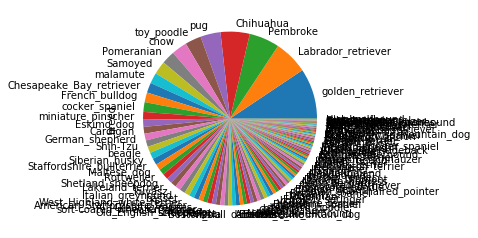

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

print('The highest rating ratio breed is {}'.format(df[df.rating_ratio == df.rating_ratio.max()].breed.values))
df.breed.value_counts().plot(kind='pie')
plt.show()

從資料來說，我們發現 @WeRateDog 評過的狗品種至少有 113種，比較多數的前四名品種依序為：

1) Golden retriever 2) Labrador retriever 3) Pembroke 4) Chihuahua

曾經得到最高評分的是 Pomeranian，結果跟上面不同。顯然品種跟評分沒有關係。

不過，我不禁想問：Q3. @WeRateDog 的評分有特定的範圍嗎？有特定的 pattern 嗎？

In [11]:
df.rating_ratio.describe()

count    1663.000000
mean        1.087723
std         0.251692
min         0.000000
25%         1.000000
50%         1.100000
75%         1.200000
max         7.500000
Name: rating_ratio, dtype: float64

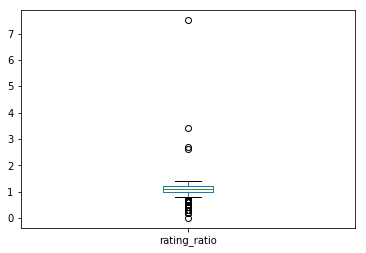

In [10]:
df.rating_ratio.plot.box()
plt.show()

從 `describe` 顯示 mean 1.09, std 0.25，可見資料相當的分散；箱型圖也顯示有很多 outlier，這樣看來 @WeRateDog 在推文給的評價很隨心所欲，並不是有什麼一定的 ratio 範圍。

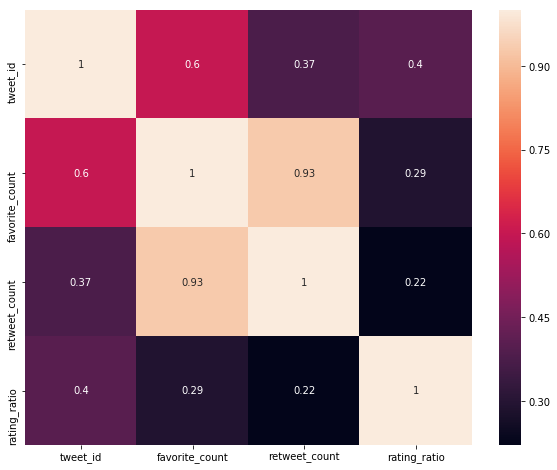

In [14]:
# 使用seaborn的熱度圖觀察表徵之間的線性關聯
import seaborn as sns
plt.figure(figsize=(10, 8))
feature_corr = df.corr()
sns.heatmap(feature_corr, annot=True)

> 上面欄位 tweet_id，data level 是 nominal，因此先忽略該欄位。

滿意外的，熱度圖顯示 @WeRateDog tweet 的 rating ratio 跟 favorite count and retweet count 並沒有很強烈的關係。

那 favorite count and retweet count 之間是高度正相關則在意料之中。

這邊我們可以得知一件事：@WeRateDog 的評分跟其他人按讚數、轉貼有沒有關係。

那問題就來到了"推文讓大眾轉貼或按讚的原因是什麼？"

查看欄位，我們還有兩個要素可以觀察大眾按讚的原因
- the stages of dog: doggo, floofer, pupper, puppo
- tweet time: created_at

**_The stage of dog_**

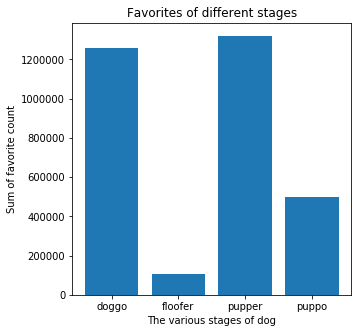

In [18]:
doggo = df.groupby('doggo').favorite_count.sum()[1]
floofer = df.groupby('floofer').favorite_count.sum()[1]
pupper = df.groupby('pupper').favorite_count.sum()[1]
puppo = df.groupby('puppo').favorite_count.sum()[1]

plt.subplots(figsize=(5, 5))
labels = ['doggo','floofer','pupper','puppo']
plt.bar(labels, [doggo,floofer,pupper,puppo])
plt.title('Favorites of different stages')
plt.xlabel('The various stages of dog')
plt.ylabel('Sum of favorite count')
plt.show()

bar chart 顯示推文的狗 stage 為 pupper and doggo，一般會得到大家的喜歡。

**_Time_**

Text(0, 0.5, 'Sum of favorite count')

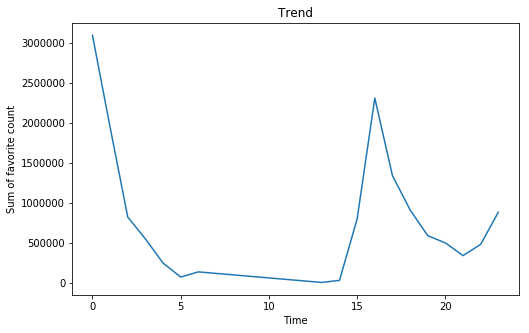

In [24]:
df.created_at = pd.to_datetime(df.created_at)
plt.subplots(figsize=(8, 5))
plt.plot(df.groupby(df.created_at.dt.hour).favorite_count.sum())
plt.title('Trend')
plt.xlabel('Time')
plt.ylabel('Sum of favorite count')

BinGo! Trend chart 顯示有兩段時間（00:00 - 03:00, 15:00 - 20:00）是 favorite count 的高峰期，可見推文的時間是影響大眾對 @WeRateDog 推文點讚的關鍵原因！